# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomResizedCrop(32),       
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10('./CIFAR10_data/train', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10('./CIFAR_10_data/test', train=False, download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

In [4]:
# Explore data
# show5(testloader)

dataiter = iter(testloader)
batch = next(dataiter)

print("Images shape: ", batch[0][0].shape)

print("Label shape: ", batch[1].shape)

print(trainset)
print("\n")
print(testset)


Images shape:  torch.Size([3, 32, 32])
Label shape:  torch.Size([32])
Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./CIFAR10_data/train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-30, 30), resample=False, expand=False)
                             RandomHorizontalFlip(p=0.5)
                             RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./CIFAR_10_data/test
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.cl1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # output = 32*32*32
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.cl2 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output = 32*32*32
        self.pool1 = nn.MaxPool2d(2,2) # output = 32*16*16
        
        self.cl3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # output = 64*16*16
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.cl4 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output = 64*16*16
        self.pool2 = nn.MaxPool2d(2,2) # output = 64*8*8
        
        self.cl5 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output = 128*8*8
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.cl6 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output = 128*8*8
        self.pool3 = nn.MaxPool2d(2,2) # output = 128*4*4
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # Conv Layer 1st block
        x = F.relu(self.cl1(x))
        x = self.batch_norm1(x)
        x = F.relu(self.cl2(x))
        x = self.pool1(x)
        
        # Conv Layer 2nd block
        x = F.relu(self.cl3(x))
        x = self.batch_norm2(x)
        x = F.relu(self.cl4(x))
        x = self.pool2(x)
        
        # Conv Layer 3rd block
        x = F.relu(self.cl5(x))
        x = self.batch_norm3(x)
        x = F.relu(self.cl6(x))
        x = self.pool3(x)
        
        # Fully connected layer
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
    
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x
    

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:


model = Classifier()
print(model)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Classifier(
  (cl1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cl2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cl3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cl4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cl5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cl6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

epochs = 20
steps = 0
print_every = 250

train_losses = []
test_losses = []

running_loss = 0

for e in range(epochs):
    
    for images, labels in trainloader:
        steps += 1
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            
            model.eval()
            
            with torch.no_grad():
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    
                    log_ps = model.forward(images)
                    test_loss += criterion(log_ps, labels)
                    
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
            model.train()
            
            train_losses.append(running_loss/print_every)
            test_losses.append(test_loss/len(testloader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/print_every),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        
            running_loss = 0



Epoch: 1/20..  Training Loss: 2.194..  Test Loss: 1.952..  Test Accuracy: 0.284
Epoch: 1/20..  Training Loss: 1.939..  Test Loss: 1.728..  Test Accuracy: 0.361
Epoch: 1/20..  Training Loss: 1.887..  Test Loss: 1.711..  Test Accuracy: 0.371
Epoch: 1/20..  Training Loss: 1.816..  Test Loss: 1.573..  Test Accuracy: 0.424
Epoch: 1/20..  Training Loss: 1.781..  Test Loss: 1.573..  Test Accuracy: 0.419
Epoch: 1/20..  Training Loss: 1.763..  Test Loss: 1.586..  Test Accuracy: 0.423
Epoch: 2/20..  Training Loss: 1.728..  Test Loss: 1.490..  Test Accuracy: 0.454
Epoch: 2/20..  Training Loss: 1.724..  Test Loss: 1.553..  Test Accuracy: 0.445
Epoch: 2/20..  Training Loss: 1.660..  Test Loss: 1.442..  Test Accuracy: 0.475
Epoch: 2/20..  Training Loss: 1.668..  Test Loss: 1.442..  Test Accuracy: 0.473
Epoch: 2/20..  Training Loss: 1.632..  Test Loss: 1.382..  Test Accuracy: 0.502
Epoch: 2/20..  Training Loss: 1.609..  Test Loss: 1.398..  Test Accuracy: 0.495
Epoch: 3/20..  Training Loss: 1.617..  T

Plot the training loss (and validation loss/accuracy, if recorded).

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

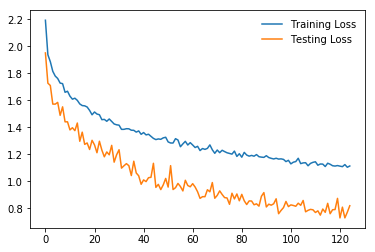

In [9]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend(frameon=False)


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
accuracy = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        log_ps = model.forward(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    print("Test Accuracy Percentage: {:.3f}%".format(accuracy/len(testloader)*100))

Test Accuracy Percentage: 73.223%


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

My model performed better than Detectocorp's model! In order to achieve this accuracy of >70%, I had to use a convolutional neural network setup with 3 convolutional layers and 2 fully connected layers. Also, along the way, adding I had to add an extra convolutional layer, batch normalization and padding to achieve a higher accuracy compared to earlier models. To further improve the accuracy, we can train the model for more epochs, add additional regularization techniques such as dropout on the convolution and fully connected layers.

In Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020, more advanced models can be created by using the ensemble method of training multiple models and combining them to achieve a better result.

We should definitely go ahead to build our own image classifier rather than buying it off Detectocorp, since building it inhouse already exceeds the benchmark set by Detectocorp. Moreover, we can continue to improve the accuracy based by implementing more advanced models based on existing research literatures.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).